In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM , GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import math

In [2]:
warnings.filterwarnings('ignore')

from itertools import product<br>
import statsmodels.api as sm<br>
from itertools import cycle<br>
import plotly.offline as py<br>
import plotly.graph_objects as go<br>
import plotly.express as px<br>
from plotly.subplots import make_subplots<br>
import math<br>
import datetime as dt<br>
import os

In [3]:
plt.style.use('seaborn-darkgrid')
dolar_data_set = pd.read_csv("NVDA.csv")
group = dolar_data_set[['Close']]

In [4]:
prediction_days = 1000

In [5]:
df_train = group[:len(group) - prediction_days].values.reshape(-1, 1)
df_test = group[len(group) - prediction_days:].values.reshape(-1, 1)

In [6]:
chosen_col = 'Close'

In [7]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

In [8]:
scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [9]:
def dataset_generator_lstm(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
trainX, trainY = dataset_generator_lstm(scaled_train)

In [11]:
testX, testY = dataset_generator_lstm(scaled_test)

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

In [13]:
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [14]:
model = Sequential()
model.add(GRU(units=128, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 128)            50304     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 87,617
Trainable params: 87,617
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
checkpoint_path = 'my_best_model2.hdf5'

In [17]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [18]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:
callbacks = [checkpoint, earlystopping]

In [20]:
history = model.fit(trainX, trainY, batch_size=32, epochs=300, verbose=1, shuffle=False, validation_data=(testX, testY),
                    callbacks=callbacks)

Epoch 1/300
101/103 [============================>.] - ETA: 0s - loss: 0.0026   
Epoch 1: val_loss improved from inf to 0.09924, saving model to my_best_model2.hdf5
103/103 [==============================] - 5s 14ms/step - loss: 0.0029 - val_loss: 0.0992
Epoch 2/300
100/103 [============================>.] - ETA: 0s - loss: 0.0166
Epoch 2: val_loss did not improve from 0.09924
103/103 [==============================] - 1s 8ms/step - loss: 0.0179 - val_loss: 0.1620
Epoch 3/300
 98/103 [===========================>..] - ETA: 0s - loss: 0.0217
Epoch 3: val_loss did not improve from 0.09924
103/103 [==============================] - 1s 8ms/step - loss: 0.0233 - val_loss: 0.1950
Epoch 4/300
 99/103 [===========================>..] - ETA: 0s - loss: 0.0408
Epoch 4: val_loss improved from 0.09924 to 0.06304, saving model to my_best_model2.hdf5
103/103 [==============================] - 1s 7ms/step - loss: 0.0431 - val_loss: 0.0630
Epoch 5/300
102/103 [============================>.] - ETA: 0s

In [21]:
model_from_saved_checkpoint = load_model(checkpoint_path)

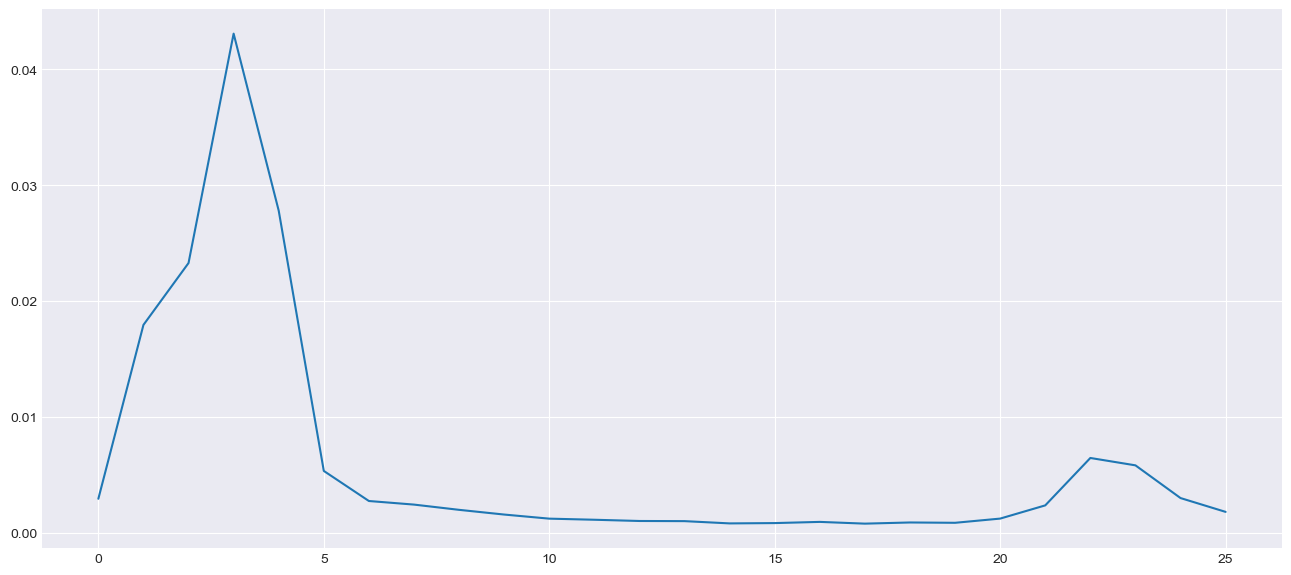

In [22]:
plt.figure(figsize=(16, 7))
plt.plot(history.history['loss'], label='train')

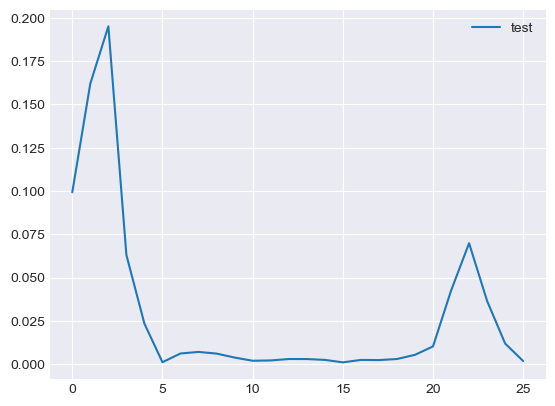

In [23]:
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
predicted_dolar_price_train_data = model_from_saved_checkpoint.predict(trainX)

103/103 [==============================] - 1s 3ms/step


In [25]:
predicted_dolar_price_train_data = scaler_train.inverse_transform(predicted_dolar_price_train_data.reshape(-1, 1))

In [26]:
train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

In [27]:
plt.figure(figsize=(16, 7))

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

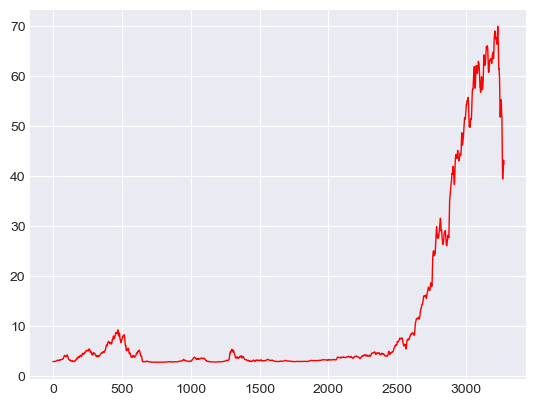

In [28]:
plt.plot(predicted_dolar_price_train_data, 'r', label='Education Estimated Price', linewidth="1")

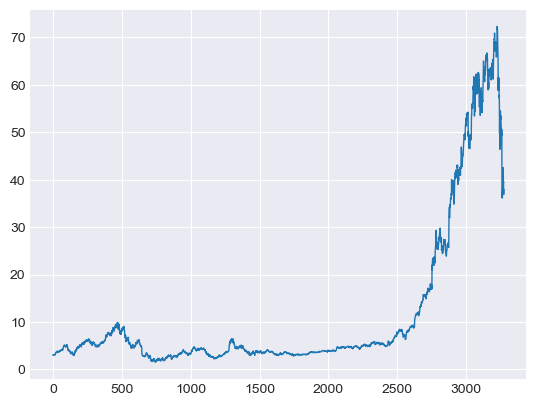

In [29]:
plt.plot(train_actual, label='Real Price', linewidth="1")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


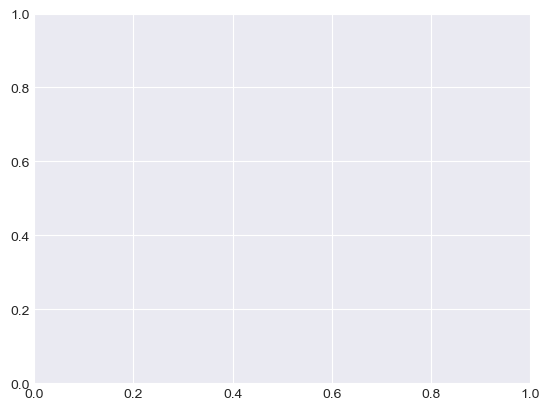

In [30]:
plt.legend()
plt.show()

In [31]:
predicted_dolar_price_test_data = model_from_saved_checkpoint.predict(testX)

32/32 [==============================] - 0s 3ms/step


In [32]:
predicted_dolar_price_test_data = scaler_test.inverse_transform(predicted_dolar_price_test_data.reshape(-1, 1))

In [33]:
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

-------------------------------------------------------

In [34]:
plt.figure(figsize=(16, 7))

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

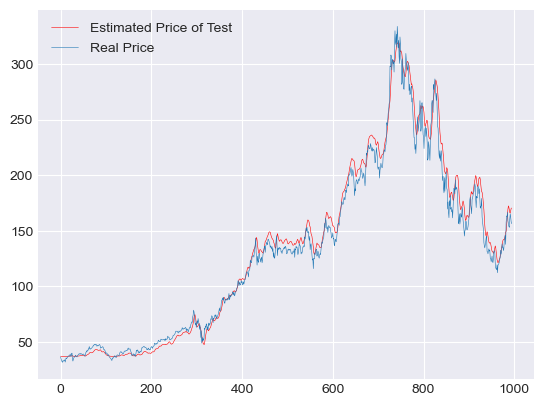

In [35]:
plt.plot(predicted_dolar_price_test_data, 'r', label='Estimated Price of Test', linewidth="0.4")
plt.plot(test_actual, label='Real Price', linewidth="0.4")
plt.legend()
plt.show()

In [36]:
lookback_period = 15

In [37]:
testX_last_5_day = testX[testX.shape[0] - lookback_period:]

In [38]:
predicted_5_days_forecast_price_test_x = []

In [39]:
for i in range(15):
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_day[i:i + 1])
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
    predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

1/1 [==============================] - 0s 16ms/step


In [40]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

In [41]:
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()

In [42]:
predicted_dolar_price_test_data = predicted_dolar_price_test_data.flatten()

In [43]:
predicted_dolar_test_concatenate = np.concatenate(
    (predicted_dolar_price_test_data, predicted_5_days_forecast_price_test_x))

----------------------------------------------------------------------------

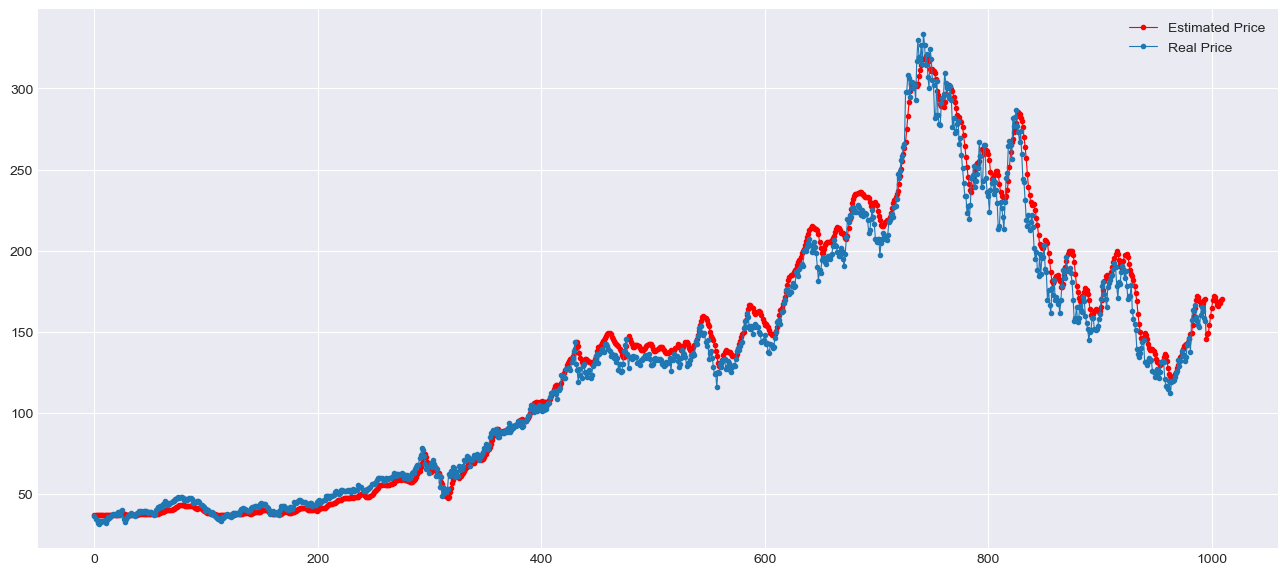

In [44]:
plt.figure(figsize=(16, 7))
plt.plot(predicted_dolar_test_concatenate, 'r', marker='.', label="Estimated Price", linewidth="0.8", alpha=1)
plt.plot(test_actual, label="Real Price", marker='.', linewidth="0.8")
plt.legend()
plt.show()

In [45]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_dolar_price_test_data))
print('Test RMSE: %.3f' % rmse_lstm_test)

Test RMSE: 9.718


In [46]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_dolar_price_train_data))

In [47]:
print('Train RMSE: %.3f' % rmse_lstm_train)

Train RMSE: 1.236
